In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-lda.txt')
data.head()

,PersonID,ItemID
0,1,105
1,1,80
2,1,54
3,1,120
4,1,6


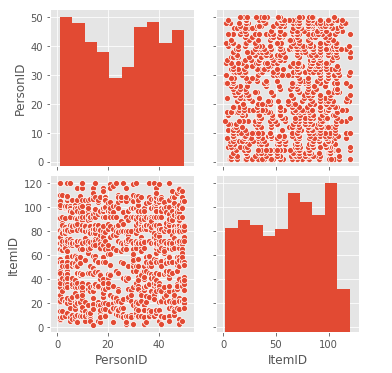

In [3]:
sns.pairplot(data)

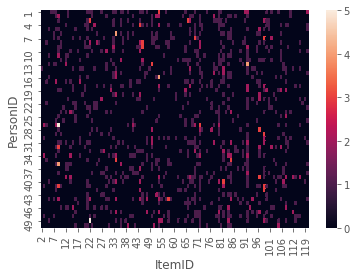

In [4]:
sns.heatmap(pd.crosstab(index=data['PersonID'], columns=data['ItemID']))

In [5]:
stan_model = """
  
  functions {
    real CateCate_lpmf(int Y, int K, vector theta, vector[] phi){
      vector[K] lp;
      for (k in 1:K){
        lp[k] = log(theta[k]) + log(phi[k, Y]);
      }
      return log_sum_exp(lp);
    }
  }

  data {
    int<lower=1> E;
    int<lower=1> N;
    int<lower=1> I;
    int<lower=1>K;
    int<lower=1, upper=N> PersonID[E];
    int<lower=1, upper=I> ItemID[E];
    vector<lower=0>[I] Alpha;

  }

  parameters {
    simplex[K] theta[N];
    simplex[I] phi[K];
  }

  model {
    for (k in 1:K){
      phi[k] ~ dirichlet(Alpha);
    }
    
    for (e in 1:E){
      ItemID[e] ~ CateCate(K, theta[PersonID[e]], phi);
    }
  }

"""

In [6]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3784540123a96794c94980a899b37f49 NOW.


In [7]:
stan_data = {}
stan_data['E'] = data.shape[0]
stan_data['N'] = 50
stan_data['K'] = 6
stan_data['I'] = 120
stan_data['PersonID'] = data['PersonID']
stan_data['ItemID'] = data['ItemID']
stan_data['Alpha'] = np.ones(120) / 2

In [8]:
fit = sm.vb(stan_data)

In [9]:
fit.keys()

odict_keys(['args', 'inits', 'sampler_params', 'sampler_param_names', 'mean_pars', 'mean_par_names'])

In [10]:
result = pd.read_csv(fit['args']['sample_file'].decode('utf-8'), comment='#')
result.head()

,lp__,log_p__,log_g__,theta.1.1,theta.2.1,theta.3.1,theta.4.1,theta.5.1,theta.6.1,theta.7.1,...,phi.3.119,phi.4.119,phi.5.119,phi.6.119,phi.1.120,phi.2.120,phi.3.120,phi.4.120,phi.5.120,phi.6.120
0,0,0.00,0.000,0.285236,0.081926,0.104182,0.128385,0.120572,0.132488,0.224329,...,0.032011,0.005347,0.019200,0.026391,0.079055,0.023017,0.069368,0.039881,0.065708,0.070879
1,0,-7205.03,-490.166,0.288775,0.047338,0.091204,0.120323,0.154583,0.130457,0.523049,...,0.000531,0.025900,0.001712,0.023450,0.004282,0.002718,0.011566,0.013479,0.006308,0.000729
2,0,-7173.54,-480.554,0.575817,0.083949,0.097745,0.020367,0.319672,0.050336,0.319763,...,0.012777,0.000412,0.001938,0.048350,0.021159,0.000178,0.000241,0.004042,0.006642,0.001883
3,0,-7133.04,-472.907,0.219647,0.284733,0.033831,0.075614,0.303412,0.321380,0.175399,...,0.002557,0.017480,0.001790,0.000001,0.010326,0.002717,0.006387,0.002711,0.017653,0.004930
4,0,-7128.10,-447.742,0.355309,0.042386,0.222013,0.111900,0.123791,0.124190,0.416451,...,0.000105,0.000733,0.007206,0.000398,0.005207,0.000116,0.009495,0.007596,0.008021,0.006996


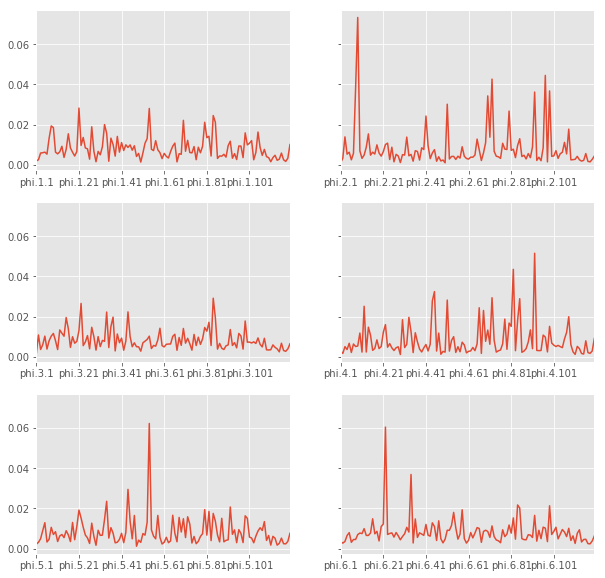

In [11]:
import re

n_show = 6
n_plot_row = 3
n_plot_col = 2

fig, axes = plt.subplots(n_plot_row, n_plot_col, figsize=(10, 10), sharey=True)

for i in range(n_plot_row * n_plot_col):
    plot_r= i // n_plot_col
    plot_c = i % n_plot_col
    ax = axes[plot_r, plot_c]
    offset = i * n_show
    phi_topic_index_columns = [x for x in result.columns if re.search('phi\.[{}]+\.[0-9]'.format(i+1), x)]
    result[phi_topic_index_columns].mean(axis=0).plot(ax=ax)

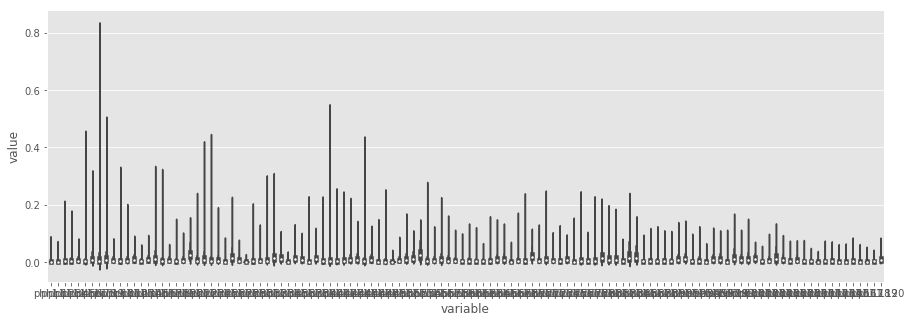

In [12]:
plt.rcParams['figure.figsize'] = [15, 5]
i=0
phi_topic_index_columns = [x for x in result.columns if re.search('phi\.[{}]+\.[0-9]'.format(i+1), x)]
sns.violinplot(data=result[phi_topic_index_columns].melt(), x='variable', y='value')

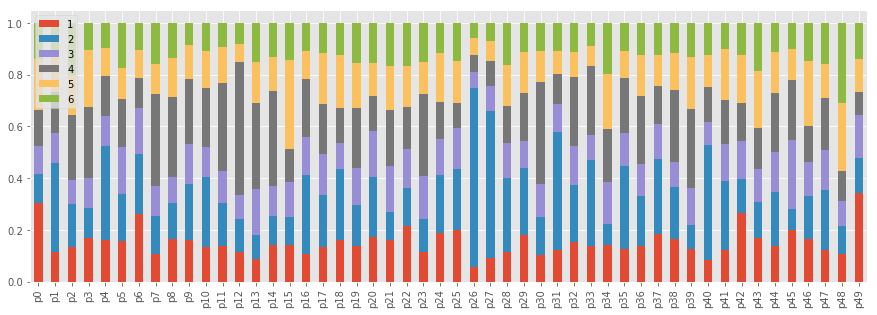

In [13]:
bar_df = pd.DataFrame([])
for i in range(50):
    theta_person_index_columns = [x for x in result.columns if re.search('theta\.{}\.[0-9]+'.format(i+1), x)]
    person_df = result[theta_person_index_columns].mean(axis=0)
    person_df.index = [1, 2, 3, 4, 5, 6]
    person_df.name = 'p{}'.format(i)
    bar_df = pd.concat([
        bar_df,
        person_df
   ], axis=1)

bar_df.T.plot.bar(stacked=True)


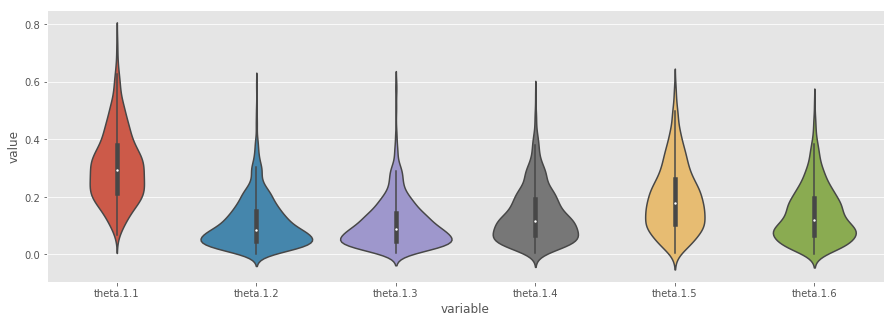

In [14]:
i=0
theta_person_index_columns = [x for x in result.columns if re.search('theta\.{}\.[0-9]+'.format(i+1), x)]
sns.violinplot(data=result[theta_person_index_columns].melt(), x='variable', y='value')